# PyTorch Neural Network Classification
## What is a classification problem?
A classification problem involves predicting whether something is one thing or another.

|Problem type|What is it?|Example|
|--|--|--|
|Binary classification|Target can be one of two options, eg., yes or no|Predict whether or not someone has heart disease based on their health parameters.|
|Multi-class classification|Target can be one of more than two options|Decide whether a photo is of food, a person or a dog.|
|Multi-label classifcation|Target can be assigned more than one option|Predict what category is should be assigned to a Wikipedia article (eg., mathematics, science or philosophy).|

## Architecture of a classification neural network

|Hyperparameter|Binary Classification|Multiclass classification|
|--|--|--|
|Input layer shape (in_features)|Same as number of features (eg., 5 for age, sex, height, weight, smoking status in heart disease prediction)|Same as binary classfication|
|Hidden layer(s)|Problem specific, minimum = 1, maximum = unlimited|Same as binary classfication|
|Neurons per hidden layer|problem specific, generally 10 to 512|Same as binary classification|
|Output layer shape (out_features )|1 (one class or the other)|1 per class (eg., 3 for food, person, or dog photo)|
|Hidden layer activation|Usually ReLU but can be many others|same as binary classification|
|Output activation|Sigmoid (torch.sigmoid in PyTorch)|Softmax (torch.softmax in PyTorch)|
|Loss function|Binary crossentropy (torch.nn.BCELoss in PyTorch)|Cross entropy (torch.nn.CrossEntropyLoss in PyTorch)|
|Optimizer|SGD (Stochastic gradient descent), Adam (torch.optim)|Same as binary classification|

### 1. Make classification data and get it ready
Let's begin by making some data.

We will use the `make_circles()` method from Scikit-Learn to generate two circles with different coloured dots.

In [111]:
!pip install -q -q scikit-learn

In [7]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

Alright, now let's view the first 5 X and y values.

In [11]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


Looks like there's two X values per one y value.

Let's keep following the data explorer's motto of visualize, visualize, visualize and put them into a pandas DataFrame.

In [14]:
!pip install pandas

In [15]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


It looks like each pair of X features (X1 and X2) has a label (y) value of either 0 or 1.

This tells us that our problem is binary classification since there's only two options (0 or 1).

How many values of each class are there?

In [17]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

Let's plot them.

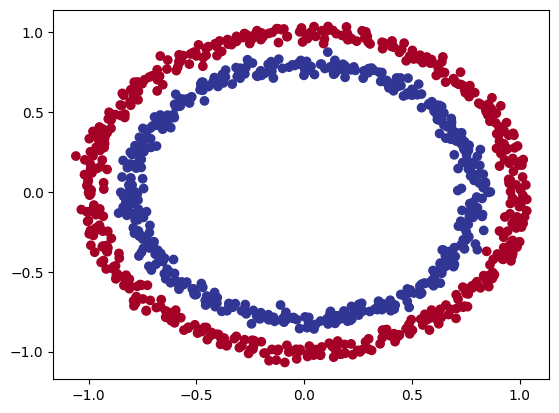

In [22]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

Alrighty, looks like we've got a problem to solve.

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

#### 1.1 Input and output shapes
One of the most scommon erros in deep learning is shape errors.
Mismatching the shapes of tensors and tensor operations iwll result in errors in yoru models.
We're going to see plenty of these throughout the course.
And there's no surefire way to make sure they won't happen, they will.
What you can do instead is continually familiarize yourself with the shape of tyhe data you're working with.
I like referring to it as inout and output shapes.

In [27]:
# Check the shapes of our fetures and labels
X.shape, y.shape

((1000, 2), (1000,))

Looks like we've got a match on the first dimension of each.

There's 1000 X and 1000 y.

But what's the second dimension on X?

It often helps to view the values and shapes of a single sample (features and labels).

Doing so will help you understand what input and output shapes you'd be expecting from your model

In [30]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


#### 1.2 Turn data into tensors and careate train and test splits
We've investigated the input and output shapes of our data, not let's prepare it for being used with PyTorch and for modelling.

Specifically, we'll need to:
1. Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).
2. Split our data into training and test sets (we'll train a model on the traiing set to learn the patterns between `X` and `y` and then evaluate theose learned patterns on the test dataset)

In [33]:
# Turn data into tensors
# Otherwise this cause issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

Now our data is in tensor format, let's split it into training and test sets.

To do so, let's use the helpful function `train_test_split()` from Scikit-Learn.

We'll use `test_size=0.2` (80% training, 20% testing) and because the split happends randomly across the data, let's use `random_state=42` so the split is reproducible.

In [35]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2. Building a model
We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.
1. Setting up device agnostic code (so our model can run on CPU or GPU it it's available)j.
2. constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).

The good news is we've been through all of the above steps before in notebook 01.

Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and `torch.nn` as well as settting up device agnostic code.

In [39]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

How about we create a model?

We'll wwant a model capable of handling our `X` data as inputs and producing somehing in the shape of our `y` data as outputs.

In other workds, given `X` (features) we want our model to predict `y` (label).

This setup where you have features and labels is referred to as supervised learning. Because your data is telling yoru model what the outputs should be given a certain input.

To create such a model it'll need to handle the input and output shapes fo `X` and `y`.

Remember how I said inpout and output shapes are important? Here we'll see why.

Let's create a model class that:

1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.lModule`).
2. Create 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.

In [43]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

        # 3. Define a forward method containing the forward pass computation
        def forward(self, x):
            # Return the joutput of layer_2, a single feature, the same shape as y
            return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

What's going on here?

We've seen a few of these steps before.

The only major change is what's happening between `self.layer_1` and `self.layer_2`.

`self.layer_1` takes 2 input features `in_features=2` and produces 5 output features `out_features=5`.

This is known as having 5 hidden units or neurons.

Why do this?

This allows the model to learn pattern from 5 numbers rather than just 2 numbers, potentially leading to better outputs.

I say potentially because sometimes it doesn't work.

The number of hidden units you can use in neural network layers is a hyperparameter (a value you can set yourself) and there's no set in stone value you have to use.

Generally more is better but there's also such a thing as too much. the amount you choose will depend on your lmodel type and dataset you're working with.

Since our dataset is small and simple, we'll keep it small.

The only rule with hidden units is that th next layer, in our case, `self.layer_2` has to take the same `in_features` as the previous layer `out_features`.

That's why `self.layer_2` and `in_features=5`, it takes the `out_features=5` from `self.layer_1` and performs a linear computation on them, turning them into `out_fautres=1` (the same shape as `y`).

You can also do the same as above using `nn.Sequential`.

`nn.Sequential` perofrms a forward pass computation of the input data through the layers in the order they appear.

In [47]:
# Replicate circleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Woah, that looks much simpler that subclassing `nn.Module`, why not just always use `nn.Sequential`? 

`nn.Sequential` is fantastic for straight-forward computations, however, as teh namespace says, it always runs in sequential order.

So if you'd like something else to happen (rather than just straight=forward sequential computation) you'll want to define your own custom `nn.Module` subclass.

Now we've got a model, let's see what happens when we pass some data through it.

In [52]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.9975],
        [-0.9916],
        [-0.8249],
        [-1.0471],
        [-0.5265],
        [-0.5252],
        [-0.7452],
        [-0.6352],
        [-0.8378],
        [-0.9879]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#### 2.1 Setup loss function and optimizer
We've setup a loss (also called a criterion or cost function) and optimizer in notebook 01.

But different problem types require different loss functions.

For example, for a regression problem (predicting a number) you might use mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use binary cross entropy as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, `torch.optim.SGD()`) can be used for a range of problems, and the same applies to the Adam optimizer `torch.optim.Adam()`).

|Loss function/Optimizer|Problem type|PyTorch Code|
|--|--|--|
|Stochastic Gradient Descent (SGD) optimizer|Classification, regression, many others.|`torch.optim.SGD()`|
|Adam Optimizer|Classification, regression, many others.|`torch.optim.Adam()`|
|Binary cross entropy loss|Binary classification|`torch.nn.BCELossWithLogits` or `torch.nn.BCELoss`|
|Cross entropy loss|Multi-class classification|`torch.nn.CrossEntropyLoss`|
|Mean absolute error (MAE) or L1 Loss|Regression|`torch.nn.L1Loss`|
|Mean squared error (MSE) or L2 Loss|Regression|`torch.nn.MSELoss`|

PyTorch has 2 binary cross entropy implementations:
1. `torch.nn.BCELoss()`: Creates a loss function taht measures the binary cross entropy between the target (label) and input (features).
2. `torch.nn.BCEWithLogitsLoss()`: This is the same as above except it has a sigmoid layer (`nn.sigmoid`) built-in (we'll see what this means soon).

Which one should you use?

The documentation for `torch.nn.BCEWithLogictsLoss()` states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()` but that is beyond the scope of this notebook.

Knowing this, let's create a loss function and an optimizer.

For the optimizer we'll use `torch.optim.SGD()` to optimze the model parameters with learning rate 0.1.

In [57]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built0in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

Now let's also crate an evaluation metric.

An evaluation metric can be used to offer another perspective on how your model is going.

If a loss funciton measures how wrong your model is, I like to think of evaluation metrics as measuring how right it is.

Of course, you could argue bot hof these are doing the same thing but evaluation metrics offer a different perspective.

After all, when evaluating your models it's good to look at things from multiple points of view.

There are several evaluation metrics that can be used for classification broblems but let's start out with accuracy.

Accuracy can be mesured by dividing the total number of correct predictions over the toal number of predictions.

For example, a model that makes 99 correct predictions out of 100 will have an accuracy of 99%.

Let's write a function to do so.

In [61]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### 3. Train model
PyTorch training loop steps
1. Forward pass: The model goes through all of the training data once, performing its `forward()` function calculations (`model(x_train)`).
2. Calculate the loss: the modle's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (`loss = loss_fn(y_pred, y_train`)
3. Zero gradients: The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (`optimizer.zero_grad()`)
4. Perform backpropagation on the loss: Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as backpropagation, hence "backwards" (`loss.backward()`).
5. Step the optimizer (gradient descent): Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them (`optimizer.step()`).

#### 3.1 Going from faw model outputs to predicted labels (logits -> probabilites -> prediction labels)

Before the training loop steps, let's see what comes out of our model during kthe forward pass (the forward pass is defined by the `forward()` method).

To do so, let's pass the model some data.

In [65]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.9975],
        [-0.9916],
        [-0.8249],
        [-1.0471],
        [-0.5265]], device='cuda:0', grad_fn=<SliceBackward0>)

Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our `forward()` method.

Which implements two layers of `nn.Layers()` which internally calls the following equation:

$
y = x \cdot Weigths^T + bias
$

The raw outputs (unmodified) of this equation (y) and in turn , the raw outputs of our model are often referred to as logits.

That's what our model is outputing above when it takes in the input data (x in the equation or `X_test` in the code), logits.

However, these numbers are hard to interpret.

We'd linke some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

Let's try it out.|

In [86]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.2694],
        [0.2706],
        [0.3047],
        [0.2598],
        [0.3713]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Okay, it seems like the outputs now have some kind of consistency (even throught they're still random).

They're now in the form of prediction probabilities (I usually refer to these as `y_pred_probs`), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, or closer to 1, the more the model thinks the sample belongs to class 1.

More specifically:
- If `y_pred_probs` >= 0.5, `y=1` (class 1)
- If `y_pred_probs` < 0.5, `y=0` (class 0)

To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function.

In [100]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

Excellent! Now it looks like our model's predictions are in the same form as our truth labels (`y_test`).

In [106]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

This means we'll be able to compare our model's predictions to the test labels to see how well it's performing.

To recap, we convert our model's raw outputs (logits) to prediction probabilities using a sigmoid activation function.

And then converted the prediction probabilitites to prediction labels by rounding them.

Note: the use of the sigmoid activation funciton is often only for binary classification logits. For multi-class classification, we'll be looking at using the softmax activation function (this will come later on).

And the use of the sigmoid activation function is not required when passing our model's raw outputs to the `nn.BCEWithLogitsLoss` (the "logits" in logit loss is because it works on the model's raw logit output), this is because it has a sigmoid function built-in.

### 3.2 Building a training and testing loop
Alright, we've discussed how to take our raw model outputs and convert them to prediction labels, now let's build a training loop.

Let's start by training for 100 epochs and outputing the model's progress every 10 epochs.

In [122]:
torch.manual_seed(42)

# Set hte number of epochs
epochs = 100

# Put data to garget device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labs

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Usiong nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening ever 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.76984, Accuracy: 50.00% | Test loss: 0.76110, Test acc: 50.00%
Epoch: 10 | Loss: 0.72160, Accuracy: 50.00% | Test loss: 0.71793, Test acc: 50.00%
Epoch: 20 | Loss: 0.70551, Accuracy: 46.00% | Test loss: 0.70378, Test acc: 46.00%
Epoch: 30 | Loss: 0.69956, Accuracy: 46.38% | Test loss: 0.69884, Test acc: 45.50%
Epoch: 40 | Loss: 0.69702, Accuracy: 48.75% | Test loss: 0.69698, Test acc: 45.00%
Epoch: 50 | Loss: 0.69575, Accuracy: 50.00% | Test loss: 0.69621, Test acc: 44.50%
Epoch: 60 | Loss: 0.69499, Accuracy: 50.25% | Test loss: 0.69585, Test acc: 44.50%
Epoch: 70 | Loss: 0.69449, Accuracy: 49.75% | Test loss: 0.69568, Test acc: 47.50%
Epoch: 80 | Loss: 0.69414, Accuracy: 49.00% | Test loss: 0.69558, Test acc: 49.50%
Epoch: 90 | Loss: 0.69388, Accuracy: 49.38% | Test loss: 0.69553, Test acc: 49.00%
